In [1]:
!pip install pytorch-metric-learning
!pip install faiss-gpu

'1.2.0'

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from pytorch_metric_learning import losses, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator


### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x


### MNIST code originally from https://github.com/pytorch/examples/blob/master/mnist/main.py ###
def train(model, loss_func, device, train_loader, optimizer, loss_optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        loss_optimizer.zero_grad()
        embeddings = model(data)
        loss = loss_func(embeddings, labels)
        loss.backward()
        optimizer.step()
        loss_optimizer.step()
        if batch_idx % 100 == 0:
            print("Epoch {} Iteration {}: Loss = {}".format(epoch, batch_idx, loss))


### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)


### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set, model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, test_labels, train_embeddings, train_labels, False
    )
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))


device = torch.device("cuda")

img_mean, img_std = (0.1307,), (0.3081,)

transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize(img_mean, img_std)]
)

batch_size = 64

dataset1 = datasets.MNIST(".", train=True, download=True, transform=transform)
dataset2 = datasets.MNIST(".", train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(
    dataset1, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(dataset2, batch_size=batch_size)

model = Net().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
num_epochs = 2


### pytorch-metric-learning stuff ###
loss_func = losses.SubCenterArcFaceLoss(num_classes=10, embedding_size=128).to(device)
loss_optimizer = torch.optim.Adam(loss_func.parameters(), lr=1e-4)
accuracy_calculator = AccuracyCalculator(include=("precision_at_1",), k=1)
### pytorch-metric-learning stuff ###

## Train the model

In [ ]:
for epoch in range(1, num_epochs + 1):
    train(model, loss_func, device, train_loader, optimizer, loss_optimizer, epoch)
    test(dataset1, dataset2, model, accuracy_calculator)

## Get outliers

In [3]:
train_embeddings, train_labels = get_all_embeddings(dataset1, model)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1875/1875 [00:07<00:00, 246.32it/s]


In [4]:
outliers, _ = loss_func.get_outliers(train_embeddings, train_labels.squeeze(1))
print(f"There are {len(outliers)} outliers")

There are 144 outliers


## View some sample outliers

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(img_mean, img_std)], std=[1 / s for s in img_std]
)


def imshow(img, figsize=(8, 4)):
    img = inv_normalize(img)
    npimg = img.numpy()
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def imshow_many(dataset, outliers, n=32):
    imgs = [
        dataset[outliers[i]][0]
        for i in np.random.choice(
            len(outliers), size=min(n, len(outliers)), replace=False
        )
    ]
    imshow(torchvision.utils.make_grid(imgs))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


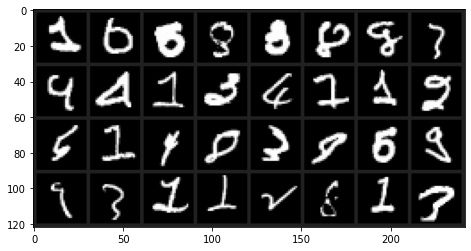

In [23]:
# let's see what outliers are.
# these are the samples that >threshold degrees aways from their dominant centers
imshow_many(dataset1, outliers)